The goal of this analysis is to showcase the effectiveness of the marketplace provided by our product, iQueue. We have the data for the 'Exchange' transactions that happened via iQueue for a new customer of LeanTaaS. 'iQueue' is a software product used to free up capacity in operating rooms and create a much more transparent and surgeon-centric process for measuring Operating Room (OR) utilization.

In [198]:
#Import the required Python libraries
import random
import sqlite3
import numpy as np
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [199]:
#Connect to database and extract the exchange_transactions table 
sqlite_file = 'LeanTaaSTestDB.db'
conn = sqlite3.connect(sqlite_file)
extr = pd.read_sql_query("SELECT * FROM exchange_transactions", conn)

In [203]:
print("Dimensions of the exchange transactions table are: {}".format(extr.shape))

Dimensions of the exchange transactions table are: (6965, 11)


In [204]:
extr.describe()

,transaction_id,parent_transaction_id,action,scheduler,surgeon,created_datetime,snapshot_date,start_time,end_time,room_name,location
count,6965,4176,6965,6965,6965,6965,6965,6965,6965,4376,6965
unique,6935,2772,9,275,357,6823,65,64,76,95,7
top,2c9180826ba0b5ad016bb3e4a083067b,2c9180826ba0b5ad016bb3e4a083067b,MARK_UPDATED,Debra Selman,Daniel Finney,2019-07-23 07:02:59.000000,2019-06-28 00:00:00.000000,07:30:00,19:00:00,MRHOR 03,MRAH OR
freq,4,4,2576,485,135,4,189,2054,1696,117,2205


From the description we can note the following points:
* We have a total of 6965 but only 6935 unique transaction ids. Some transactions have been repeated in the dataset.
* Some transactions have a parent transaction.
* A parent transaction may be the parent of 1 or more transactions.
* There are 275 schedulers in the system.
* There are 357 surgeons in the system.

We will proceed from here by deleting the repeated/duplicate transactions, converting the columns containning date and time to datetype in Python and add a column corresponding to the duration of time blocked scheduling time for the transaction.

In [205]:
#Drop rows corresponding to duplicates of transactions
extr.drop_duplicates(keep='first', inplace=True)

In [206]:
#Convert relevant columns to datetime type and add a column for duration of each transaction
extr['created_datetime'] = pd.to_datetime(extr['created_datetime'])
extr['snapshot_date'] = pd.to_datetime(extr['snapshot_date'])
extr['start_time'] = pd.to_datetime(extr['start_time'])
extr['end_time'] = pd.to_datetime(extr['end_time'])
extr['duration'] = (extr['end_time'] - extr['start_time']).dt.total_seconds()/3600

In [208]:
#Calculate number of days of operation of iQueue
max(extr['snapshot_date']) - min(extr['snapshot_date'])

Timedelta('88 days 00:00:00')

In [209]:
extr.shape[0] #Check the number of rows in the data after removing duplicates

6935

In [210]:
extr.head() #Look at the top few rows of the data table

,transaction_id,parent_transaction_id,action,scheduler,surgeon,created_datetime,snapshot_date,start_time,end_time,room_name,location,duration
0,2c91808267d2ea5301682f73e9a1093e,None,RELEASE,Jessie Shelley,Bryan Neer,2019-01-15 13:52:32,2019-07-01,2019-10-08 07:30:00,2019-10-08 19:00:00,MRAH OR 03,CENTER,11.500000
1,2c91808267d2ea5301683984e52b0bfb,None,TRANSFER,Raymond Smith,Charles Mcdonald,2019-01-17 12:47:17,2019-06-20,2019-10-08 07:30:00,2019-10-08 19:00:00,MRAH OR 06,CENTER,11.500000
2,2c91808267d2ea53016839855a480bfc,None,TRANSFER,Raymond Smith,Charles Mcdonald,2019-01-17 12:47:47,2019-06-20,2019-10-08 07:30:00,2019-10-08 19:00:00,MNOR 36,CENTER,11.500000
3,2c91808267d2eb4b016829281a390786,None,RELEASE,Kimberly Bugg,Joann Hinson,2019-01-14 08:32:01,2019-06-12,2019-10-08 08:50:00,2019-10-08 19:00:00,MNOR 25,CENTER,10.166667
4,2c91808267d2eb4b01682977274607cb,2c91808267d2eb4b016829281a390786,MARK_UPDATED,Dora Smith,Joann Hinson,2019-01-14 09:58:21,2019-06-12,2019-10-08 08:50:00,2019-10-08 19:00:00,MNOR 25,CENTER,10.166667


Here we notice that some transactions do not have a parent transaction. We will filter such 'fresh' transactions and look at the actions performed for them followed by looking at the count of locations and rooms.

In [211]:
#Filter the transactions that do not have a parent transaction
fresh_tr = extr[extr['parent_transaction_id'].isnull()]
fresh_tr['action'].value_counts()

REQUEST     1309
RELEASE     1200
TRANSFER     263
Name: action, dtype: int64

In [212]:
fresh_tr['location'].value_counts() #Count of locations

MRAH OR        858
CENTER         811
MSC OR         351
MASC OR        264
MRH OR         232
VISION OR      214
CENTER PEDS     42
Name: location, dtype: int64

In [213]:
fresh_tr['room_name'].value_counts() #Count of rooms (top and bottom few)

MRHOR 03         36
MRAH OR 10       35
MNOR 36          35
MASC OR 08       33
MMP 40 (IICT)    31
                 ..
MNOR 34           2
MSCOR 01          2
MRAH OR 08        2
MSCOR 05          1
MRAH OR 09        1
Name: room_name, Length: 95, dtype: int64

It is evident that the total of 2772 'fresh' transactions are either of type REQUEST, RELEASE or TRANSFER.

Let us look at the duration of each type of transactions by plotting histograms.

In [214]:
requests_data = fresh_tr[fresh_tr['action']=='REQUEST']
req_dur = requests_data['duration']
release_data = fresh_tr[fresh_tr['action']=='RELEASE']
rel_dur = release_data['duration']

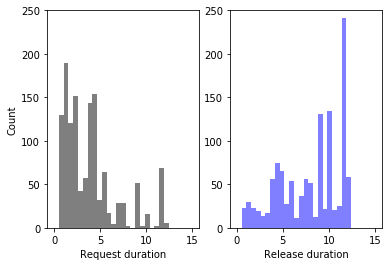

In [217]:
bins = np.linspace(0, 15, 30)
fig, ax = plt.subplots(1, 2)
ax[0].hist(req_dur, bins, alpha=0.5, color = 'black')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Request duration')
ax[0].set_ylim(0, 250)
ax[1].hist(rel_dur, bins, alpha=0.5, color = 'blue')
ax[1].set_ylim(0, 250)
ax[1].set_xlabel('Release duration')
plt.show()

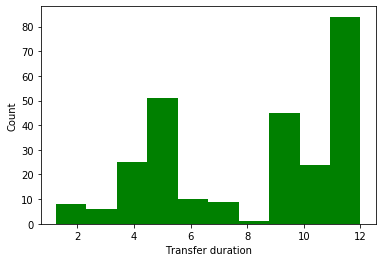

In [218]:
transfer_data = fresh_tr[fresh_tr['action']=='TRANSFER']
plt.hist(transfer_data['duration'], color = 'green')
plt.xlabel('Transfer duration')
plt.ylabel('Count')
plt.show()

Next, we will filter the transactions having a parent transaction and look at the actions performed in them.

In [219]:
notnullpar_tr = extr[extr['parent_transaction_id'].notnull()]

In [220]:
notnullpar_tr['action'].value_counts()

MARK_UPDATED        2569
APPROVE_REQUEST     1134
APPROVE_TRANSFER     256
DENY_REQUEST         174
DENY_RELEASE          23
DENY_TRANSFER          7
Name: action, dtype: int64

It is evident that the follow up transactions are of one of the types: MARK_UPDATED, APPROVE_REQUEST, APPROVE_TRANSFER, DENY_REQUEST, DENY_RELEASE, DENY_TRANSFER.

Next, we will filter some columns from the fresh transactions table, some from table having parent transactions and perform a left join on the two tables. This will give us details of the downstream transactions that took place on every parent transaction.

In [221]:
fresh = fresh_tr[['transaction_id', 'created_datetime', 'action', 'duration']]
notnull = notnullpar_tr[['parent_transaction_id', 'created_datetime', 'action']]
fresh_leftjoin_notnull = fresh.merge(notnull, left_on='transaction_id', right_on='parent_transaction_id', how='left')
fresh_leftjoin_notnull.sort_values('transaction_id').head()

,transaction_id,created_datetime_x,action_x,duration,parent_transaction_id,created_datetime_y,action_y
0,2c91808267d2ea5301682f73e9a1093e,2019-01-15 13:52:32,RELEASE,11.5,2c91808267d2ea5301682f73e9a1093e,2019-01-15 14:59:38,MARK_UPDATED
1,2c91808267d2ea5301683984e52b0bfb,2019-01-17 12:47:17,TRANSFER,11.5,2c91808267d2ea5301683984e52b0bfb,2019-01-18 06:01:54,APPROVE_TRANSFER
2,2c91808267d2ea5301683984e52b0bfb,2019-01-17 12:47:17,TRANSFER,11.5,2c91808267d2ea5301683984e52b0bfb,2019-01-18 06:02:02,MARK_UPDATED
3,2c91808267d2ea53016839855a480bfc,2019-01-17 12:47:47,TRANSFER,11.5,2c91808267d2ea53016839855a480bfc,2019-01-18 05:58:48,APPROVE_TRANSFER
4,2c91808267d2ea53016839855a480bfc,2019-01-17 12:47:47,TRANSFER,11.5,2c91808267d2ea53016839855a480bfc,2019-01-18 06:01:33,MARK_UPDATED


Now we can look at the downstream transactions for each type of parent transaction by filtering data from this table along with the processing time!

**1) TRANSFER**

In [222]:
#Filter transactions having Transfer and Mark updated actions
transfer_upd = fresh_leftjoin_notnull[(fresh_leftjoin_notnull['action_x']=='TRANSFER') & 
                                      (fresh_leftjoin_notnull['action_y']=='MARK_UPDATED')]
transfer_upd.shape[0]

256

In [223]:
#Filter transactions having Transfer and Approve transfer actions
transfer_app = fresh_leftjoin_notnull[(fresh_leftjoin_notnull['action_x']=='TRANSFER') & 
                                      (fresh_leftjoin_notnull['action_y']=='APPROVE_TRANSFER')]
transfer_app.shape[0]

256

In [224]:
 #Filter transactions having Transfer and Deny transfer actions
transfer_deny = fresh_leftjoin_notnull[(fresh_leftjoin_notnull['action_x']=='TRANSFER') & 
                                       (fresh_leftjoin_notnull['action_y']=='DENY_TRANSFER')]
transfer_deny.shape[0]

7

We note here that from the 263 TRANSFER transactions, 256 were APPROVED and MARKED UPDATED in that order. The remaining 7 transfer transactions were denied. 97.3% percent of TRANSFER transactions were APPROVED.

In [225]:
transfer_app['duration'].sum()

2085.4166666666665

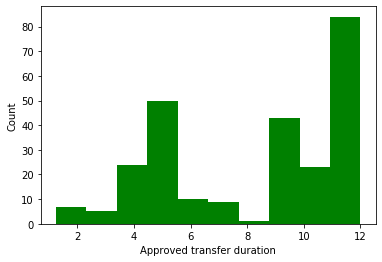

In [244]:
plt.hist(transfer_app['duration'], color = 'green')
plt.xlabel('Approved transfer duration')
plt.ylabel('Count')
plt.show()

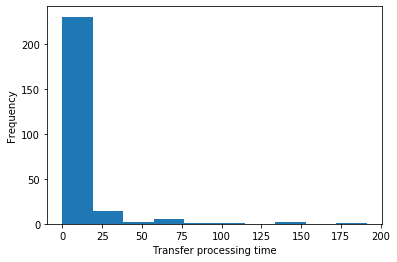

In [245]:
transfer_upd.loc[:,'process_time'] = (pd.to_datetime(transfer_upd['created_datetime_y']) - 
                                              pd.to_datetime(transfer_upd['created_datetime_x'])).dt.total_seconds()/3600
plt.hist(transfer_upd['process_time'])
plt.xlabel('Transfer processing time')
plt.ylabel('Frequency')
plt.show()

In [230]:
transfer_upd['process_time'].mean()

7.37080186631945

Over 2085 hours of time was successfully transferred during the 88 days of operation of our product. On an average, we were able to transfer 27.3 hours of time only through TRANSFERS with an average processing time of 7.37 hours with only a few outliers which take a few days to process.

**2) RELEASE**

In [231]:
#Filter transactions having Release and Mark updated actions
release_upd = fresh_leftjoin_notnull[(fresh_leftjoin_notnull['action_x']=='RELEASE') & 
                                     (fresh_leftjoin_notnull['action_y']=='MARK_UPDATED')]
release_upd.shape[0]

1178

In [232]:
#Filter transactions having Release and Deny release actions
release_den = fresh_leftjoin_notnull[(fresh_leftjoin_notnull['action_x']=='RELEASE') & 
                                     (fresh_leftjoin_notnull['action_y']=='DENY_RELEASE')]
release_den.shape[0]

23

We note here that from the 1200 RELEASE transactions, 1178 were MARKED UPDATED. The remaining 23 transfer transactions were denied. 99% percent of RELEASE transactions were APPROVED (directly MARKED UPDATED in this case).

In [233]:
release_upd['duration'].sum()

9433.833333333334

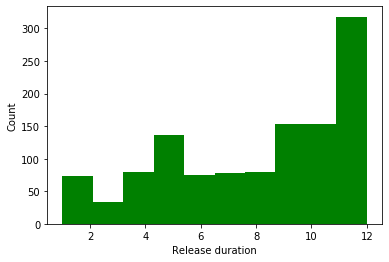

In [234]:
plt.hist(release_upd['duration'], color = 'green')
plt.xlabel('Release duration')
plt.ylabel('Count')
plt.show()

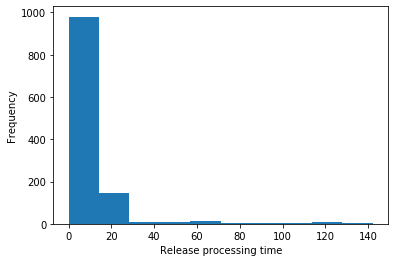

In [246]:
release_upd.loc[:,'process_time'] = ((pd.to_datetime(release_upd['created_datetime_y']) - 
                                              pd.to_datetime(release_upd['created_datetime_x']))).dt.total_seconds()/3600
plt.hist(release_upd['process_time'])
plt.xlabel('Release processing time')
plt.ylabel('Frequency')
plt.show()

In [236]:
release_upd['process_time'].mean()

7.157871156385596

About 9434 hours of time was released during the 88 days of operation of our product. On an average, 107 hours of time was RELEASED per day. The average processing time to process a release was 7.15 hours.

**3) REQUEST**

In [237]:
#Filter transactions having Request and Mark updated actions
req_upd = fresh_leftjoin_notnull[(fresh_leftjoin_notnull['action_x']=='REQUEST') & 
                                 (fresh_leftjoin_notnull['action_y']=='MARK_UPDATED')]
req_upd.shape[0]

1134

In [238]:
#Filter transactions having Request and Approve transfer actions
request_app = fresh_leftjoin_notnull[(fresh_leftjoin_notnull['action_x']=='REQUEST') & 
                                     (fresh_leftjoin_notnull['action_y']=='APPROVE_REQUEST')]
request_app.shape[0]

1134

In [239]:
 #Filter transactions having Request and Deny transfer actions
request_deny = fresh_leftjoin_notnull[(fresh_leftjoin_notnull['action_x']=='REQUEST') & 
                                      (fresh_leftjoin_notnull['action_y']=='DENY_REQUEST')]
request_deny.shape[0]

174

We note here that from the 1309 REQUEST transactions, 1134 were APPROVED and MARKED UPDATED in that order. The remaining 175 REQUEST transactions were denied. 86.6% percent of REQUESTS were APPROVED.

In [240]:
request_app['duration'].sum()

4668.25

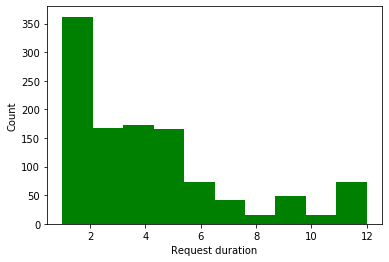

In [241]:
plt.hist(request_app['duration'], color = 'green')
plt.xlabel('Request duration')
plt.ylabel('Count')
plt.show()

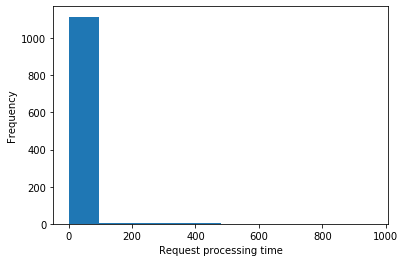

In [247]:
request_app.loc[:,'process_time'] = ((pd.to_datetime(request_app['created_datetime_y']) - 
                                              pd.to_datetime(request_app['created_datetime_x']))).dt.total_seconds()/3600
plt.hist(request_app['process_time'])
plt.xlabel('Request processing time')
plt.ylabel('Frequency')
plt.show()

In [243]:
request_app['process_time'].mean()

10.236376151283563

About 4668 hours of time was released during the 88 days of operation of our product. On an average, 53 hours of time was REQUESTED per day. 

**Conclusion:**
* 11500 hours of total time was available for transactions in 88 days.
* 6700 hours of time transferred via the transactions.
* Our product is effective in helping reduce unutilized time by more than half.
* The average processing time for a request is 10.2 hours and it is even lesser (7 hours) for release and transfer.